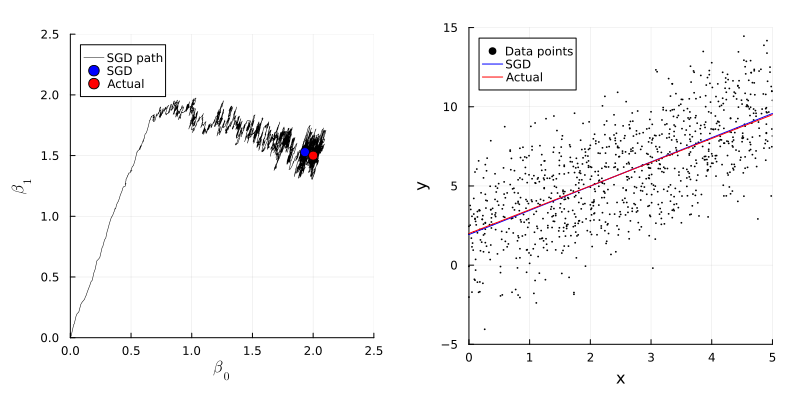

In [4]:
using Random, Distributions, Plots, LaTeXStrings, Measures
Random.seed!(1)

n = 10^3
beta0, beta1, sigma = 2.0, 1.5, 2.5
eta = 10^-3

xVals = rand(0:0.01:5,n)
yVals = beta0 .+ beta1*xVals + rand(Normal(0,sigma),n)

pts, b = [], [0, 0]
push!(pts,b)
for k in 1:10^4
    i = rand(1:n)
    g = [   2(b[1] + b[2]*xVals[i]-yVals[i]),
            2*xVals[i]*(b[1] + b[2]*xVals[i]-yVals[i])  ]#Explicit expression for the gradient
    global b -= eta*g
    push!(pts,b)
end

p1 = plot(first.(pts),last.(pts), c=:black,lw=0.5,label="SGD path")
     scatter!([b[1]],[b[2]],c=:blue,ms=5,label="SGD")
     scatter!([beta0],[beta1],
        c=:red,ms=5,label="Actual",
        xlabel=L"\beta_0", ylabel=L"\beta_1",
        ratio=:equal, xlims=(0,2.5), ylims=(0,2.5))

p2 = scatter(xVals,yVals, c=:black, ms=1, label="Data points")
     plot!([0,5],[b[1],b[1]+5b[2]], c=:blue,label="SGD")
     plot!([0,5],[beta0,beta0+5*beta1],	c=:red, label="Actual",
            xlims=(0,5), ylims=(-5,15), xlabel = "x", ylabel = "y")

plot(p1, p2, legend=:topleft, size=(800, 400), margin = 5mm)

In [6]:
using MLDatasets
train_data = MLDatasets.MNIST.traindata(Float64)

train_imgs = train_data[1]
@show typeof(train_imgs)
@show size(train_imgs)

train_labels = train_data[2]
@show typeof(train_labels);

┌ Warning: MNIST.traindata() is deprecated, use `MNIST(split=:train)[:]` instead.
└ @ MLDatasets ~/.julia/packages/MLDatasets/mtOdX/src/datasets/vision/mnist.jl:187


typeof(train_imgs) = Array{Float64, 3}
size(train_imgs) = (28, 28, 60000)
typeof(train_labels) = Vector{Int64}


In [7]:
test_data = MLDatasets.MNIST.testdata(Float64)
test_imgs = test_data[1]
test_labels = test_data[2]
@show size(test_imgs);

┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets ~/.julia/packages/MLDatasets/mtOdX/src/datasets/vision/mnist.jl:195


size(test_imgs) = (28, 28, 10000)


In [8]:
n_train, n_test = length(train_labels), length(test_labels)

(60000, 10000)

In [11]:
X = vcat([vec(train_imgs[:,:,k])' for k in 1:n_train]...)
@show size(X)
# heatmap(X, legend=false)

size(X) = (60000, 784)


(60000, 784)

In [12]:
using Flux, Statistics, Random, StatsBase, Plots
using Flux: params, onehotbatch, crossentropy, update!
Random.seed!(0)

X_test = vcat([vec(test_imgs[:,:,k])' for k in 1:n_test]...)

logistic_softmax_predict(img_vec, W, b) = softmax(W*img_vec .+ b)
logistic_sofmax_classifier(img_vec, W, b) = argmax(logistic_softmax_predict(img_vec, W, b)) - 1


function train_softmax_logistic(;mini_batch_size = 1000)
    
    #Initilize parameters
    W = randn(10,28*28)
    b = randn(10)

    opt = ADAM(0.01)
    loss(x, y) = crossentropy(logistic_softmax_predict(x, W, b), onehotbatch(y,0:9))

    loss_value = 0.0
    epoch_num = 0

    #Training loop
    while true
        prev_loss_value = loss_value
        
        #Loop over mini-batches in epoch
        start_time = time_ns()
        for batch in Iterators.partition(1:n_train, mini_batch_size)
            gs = gradient(()->loss(X'[:,batch], train_labels[batch]), params(W,b))
            for p in (W,b)
                update!(opt, p, gs[p])
            end
        end
        end_time = time_ns()

        #record/display progress
        epoch_num += 1
        loss_value = loss(X', train_labels)
        println("Epoch = $epoch_num ($(round((end_time-start_time)/1e9,digits=2)) sec) Loss = $loss_value")
        
        if epoch_num == 1 || epoch_num % 5 == 0 
            acc = mean([logistic_sofmax_classifier(X_test'[:,k], W, b) for k in 1:n_test] .== test_labels)
            println("\tValidation accuracy: $acc") 
            
            #Stopping criteria
            abs(prev_loss_value-loss_value) < 1e-3 && break
        end
    end
    return W, b
end

# Train model parameters
W, b = train_softmax_logistic();

Epoch = 1 (11.43 sec) Loss = 1.5558745308581823
	Validation accuracy: 0.7079
Epoch = 2 (4.99 sec) Loss = 0.9157372508918367
Epoch = 3 (4.54 sec) Loss = 0.7109639372746402
Epoch = 4 (5.2 sec) Loss = 0.6054271538755294
Epoch = 5 (4.49 sec) Loss = 0.5397156844845997
	Validation accuracy: 0.8744
Epoch = 6 (4.37 sec) Loss = 0.49402379669684787
Epoch = 7 (4.42 sec) Loss = 0.45987122954745197
Epoch = 8 (4.43 sec) Loss = 0.4330578113859848
Epoch = 9 (4.44 sec) Loss = 0.4112794620009553
Epoch = 10 (4.47 sec) Loss = 0.39316309233748165
	Validation accuracy: 0.8966
Epoch = 11 (4.51 sec) Loss = 0.37783240838239834
Epoch = 12 (4.5 sec) Loss = 0.36466710604462244
Epoch = 13 (4.4 sec) Loss = 0.3532116264199913
Epoch = 14 (4.42 sec) Loss = 0.343128181410476
Epoch = 15 (4.47 sec) Loss = 0.3341673396624744
	Validation accuracy: 0.9069
Epoch = 16 (4.39 sec) Loss = 0.3261454614467481
Epoch = 17 (4.4 sec) Loss = 0.3189246447692079
Epoch = 18 (4.42 sec) Loss = 0.3123975579557218
Epoch = 19 (4.42 sec) Loss =